Initialize the script by importing the right packages and enabling proper settings

In [1]:
# Mute warnings for torchvision v2
import torchvision
torchvision.disable_beta_transforms_warning()

# Importing necessary packags
import numpy as np
import torch
from torchvision.models import googlenet
import torchvision.transforms.v2 as F  
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tools.dataset import FacialExpressionDataset
from tools.engine import train_epoch, val_epoch

# Enabling autoreload
%load_ext autoreload
%autoreload 2

# Define device as GPU if cuda available, otherwise cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Define datasets for training and validation

In [2]:
train_transform = F.RandomOrder([
                F.RandomRotation(degrees=[0, 360]),
                F.RandomInvert(p=0.5),
                F.RandomHorizontalFlip(p=0.5),
                F.RandomPerspective(distortion_scale=0.9, p=0.9),
                F.ElasticTransform(alpha=250.0),
                F.RandomVerticalFlip(p=0.5),
                F.ColorJitter(),
                F.RandomGrayscale(),
                # F:RandomAffine(),
                F.RandomResizedCrop(size=(256, 256), antialias=True),
                F.RandomPosterize(6),
                F.RandomErasing(p=0.5)
            ])

In [3]:
dataset_train = FacialExpressionDataset(train_transform=train_transform, device=device)
dataset_val = FacialExpressionDataset(device=device)

if not "indices" in locals():
    indices = torch.randperm(len(dataset_train)).tolist()

dataset_train = torch.utils.data.Subset(dataset_train, indices[:(round(len(indices)*0.75))])
dataset_val = torch.utils.data.Subset(dataset_val, indices[(round(len(indices)*0.75)):])

Define dataloaders 

In [4]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset_train, BATCH_SIZE, 
                          num_workers=0, shuffle=True,
                             drop_last=False)

val_loader = DataLoader(dataset_val, BATCH_SIZE, 
                          num_workers=0, shuffle=False,
                             drop_last=False)

Create the model

In [5]:
# Import googlenet with pretrained weights from torchvision
model = googlenet(weights="DEFAULT")

# Modify the last layer to output the amount of classes we have
model.fc = torch.nn.Linear(in_features=model.fc.in_features,
                           out_features=len(dataset_train.dataset.classes))
model = model.to(device)

Define the optimizer and loss function

In [7]:
# Adam with default parameters
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)

# Cross-entropy loss for multiclass classification
loss_fn = CrossEntropyLoss().to(device)

Train for 100 epochs

In [8]:
for epoch in range(0, 100):

    train_loss, train_acc = train_epoch(model, train_loader, device, optimizer, loss_fn)
    val_loss, val_acc = val_epoch(model, val_loader, device, optimizer, loss_fn)

    print(f"Epoch {epoch:4d}  train_loss {train_loss:.4f}  train_acc {train_acc:.2f}%  val_loss {val_loss:.4f}  val_acc {val_acc:.2f}%")

Epoch    0  train_loss 1.4197  train_acc 24.72%  val_loss 1.4052  val_acc 27.38%
Epoch    1  train_loss 1.4223  train_acc 22.79%  val_loss 1.3987  val_acc 24.40%
Epoch    2  train_loss 1.3876  train_acc 30.62%  val_loss 1.3870  val_acc 25.45%
Epoch    3  train_loss 1.3734  train_acc 30.56%  val_loss 1.3794  val_acc 25.45%
Epoch    4  train_loss 1.3956  train_acc 26.96%  val_loss 1.3689  val_acc 26.34%
Epoch    5  train_loss 1.3790  train_acc 28.76%  val_loss 1.3658  val_acc 27.38%
Epoch    6  train_loss 1.3796  train_acc 28.72%  val_loss 1.3596  val_acc 28.42%
Epoch    7  train_loss 1.3630  train_acc 27.43%  val_loss 1.3572  val_acc 31.70%
Epoch    8  train_loss 1.3645  train_acc 28.76%  val_loss 1.3548  val_acc 33.78%
Epoch    9  train_loss 1.3584  train_acc 36.77%  val_loss 1.3503  val_acc 34.82%
Epoch   10  train_loss 1.3577  train_acc 34.34%  val_loss 1.3461  val_acc 38.10%
Epoch   11  train_loss 1.3639  train_acc 32.58%  val_loss 1.3438  val_acc 39.29%
Epoch   12  train_loss 1.370

KeyboardInterrupt: 

Print an image and show the emotion as the title

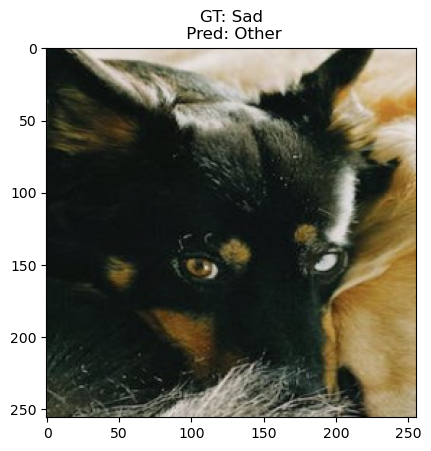

In [ ]:
model.eval()
img, label = dataset_val[5]
pred = torch.argmax(torch.softmax(model(img[None,:].to(device)), dim=1), dim=1)
img = img.permute(1, 2, 0).to(device)
plt.title("GT: " + dataset_train.dataset.classes[label] + "\n Pred: " + dataset_train.dataset.classes[pred.item()])
plt.imshow(img.detach().cpu())